<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/CalcSynergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library 



In [ ]:
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! conda config --set always_yes yes --set changeps1 no
! conda install -q -y -c conda-forge python=3.7
! conda install -q -y -c conda-forge rdkit==2020.09.2 

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem

In [ ]:
! pip install keras
! pip install tensorflow
! pip install keras-gcn
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install deepchem
! pip install keras-tuner
! pip install pubchempy
! pip install chembl_webresource_client

In [125]:
import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import pandas as pd
import numpy as np
import deepchem as dc
from rdkit import Chem
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from chembl_webresource_client.new_client import new_client
import tensorflow as tf
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
import numpy as np
import urllib
import pubchempy as pcp
import random 
import kerastuner as kt
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

#Toy data

In [ ]:
sample_01 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,1]
sample_02 = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/sample.txt",sep="\t").iloc[:,2]
all_sample = sample_01.append(sample_02).unique()
all_sample[:20]

array(['5-FU', 'ABT-888', 'AZD1775', 'BEZ-235', 'BORTEZOMIB',
       'CARBOPLATIN', 'CYCLOPHOSPHAMIDE', 'DASATINIB', 'DEXAMETHASONE',
       'DINACICLIB', 'DOXORUBICIN', 'ERLOTINIB', 'ETOPOSIDE',
       'GELDANAMYCIN', 'GEMCITABINE', 'L778123', 'LAPATINIB', 'METFORMIN',
       'METHOTREXATE', 'MITOMYCINE'], dtype=object)

#Feature Preparation

##Drug structure


In [ ]:
drug_smiles = {}
for i in all_sample:
  try:
    print(i)
    res = pcp.get_compounds(i, 'name')
    SM = res[0].canonical_smiles   
    drug_smiles[i] = SM
  except Exception:
    pass

5-FU
ABT-888
AZD1775
BEZ-235
BORTEZOMIB
CARBOPLATIN
CYCLOPHOSPHAMIDE
DASATINIB
DEXAMETHASONE
DINACICLIB
DOXORUBICIN
ERLOTINIB
ETOPOSIDE
GELDANAMYCIN
GEMCITABINE
L778123
LAPATINIB
METFORMIN
METHOTREXATE
MITOMYCINE
MK-2206
MK-4541
MK-4827
MK-5108
MK-8669
MRK-003
OXALIPLATIN
PACLITAXEL
PD325901
SN-38
SORAFENIB
SUNITINIB
TEMOZOLOMIDE
TOPOTECAN
VINBLASTINE
VINORELBINE
ZOLINZA
CHEMBL17639
BUSULFAN
AZACYTIDINE
FLUDARABINE BASE
TENIPOSIDE
NSC733504
EXEMESTANE
BLEOMYCIN
ANTIBIOTIC AD 32
MITOXANTRONE
5-FLUORO-2'-DEOXYURIDINE
MITOTANE
METHOXSALEN
FULVESTRANT
CARMUSTINE
ADM HYDROCHLORIDE
TAMOXIFEN CITRATE
CHEMBL277800
ALLOPURINOL
THIOTEPA
MERCAPTOPURINE
ANTIBIOTIC AY 22989
IFOSFAMIDE
ANASTROZOLE
VINCRISTINE SULFATE
VINBLASTINE SULFATE
IMATINIB
IMIQUIMOD
DACARBAZINE
ZOLEDRONIC ACID
QUINACRINE HYDROCHLORIDE
NILOTINIB
BENDAMUSTINE HYDROCHLORIDE
LETROZOLE
ALTRETAMINE
DOCETAXEL
DEXRAZOXANE
RALOXIFENE
CYTARABINE HYDROCHLORIDE
34793-34-5
MECHLORETHAMINE HYDROCHLORIDE
ACTINOMYCIN D
HYDROXYUREA
PROCARBAZIN

In [ ]:
list(drug_smiles.keys()).__len__()

124

In [ ]:
tmp_list = []
feat_mat = {}

curated_df = pd.DataFrame(drug_smiles.items(), columns=['Name', 'smiles'])

for i in range(curated_df.shape[0]):

  """
  create normalize adjacency matrix
  """

  mol = Chem.MolFromSmiles(curated_df.iloc[i,1])
  A = Chem.GetAdjacencyMatrix(mol).tolist()
  I = np.eye(A.__len__())

  A_hat = np.array(A + I)

  D_hat = np.array(np.sum(A_hat,axis=0))
  D_hat = np.matrix(np.diag(D_hat))
  D_hat_inv = np.sqrt(D_hat**-1)

  """
  create feaature matrix
  #https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html
  """

  f1 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetIsAromatic() for j in range(mol.GetNumAtoms())]]).T
  f2 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetDegree() for j in range(mol.GetNumAtoms())]]).T
  f3 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetImplicitValence() for j in range(mol.GetNumAtoms())]]).T
  f4 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetMass() for j in range(mol.GetNumAtoms())]]).T
  f5 = pd.DataFrame([[mol.GetAtomWithIdx(j).GetNumImplicitHs() for j in range(mol.GetNumAtoms())]]).T

  X = np.array(pd.concat([f1,f2,f3,f4,f5],axis=1)).astype(int)

  """
  multiplication A_hat*X
  """

  tmp_res = D_hat_inv * A_hat * D_hat_inv * X

  """
  Padding matrix
  """

  tmp_list.append(tmp_res)

  if i == (curated_df.shape[0]-1):
      max_atom_number = max([tmp_list[i].__len__() for i in range(curated_df.shape[0])])
      tmp_pad = pad_sequences(tmp_list, padding='post',maxlen=max_atom_number)
      
      for j in range(curated_df.shape[0]):
        feat_mat[curated_df.iloc[j,0]] = tmp_pad[j]

In [ ]:
feat_mat

{'1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE': array([[ 0,  1,  2, 10,  2],
        [ 0,  1,  2, 12,  2],
        [ 0,  2,  2, 12,  2],
        [ 0,  2,  2, 12,  2],
        [ 0,  2,  1, 13,  1],
        [ 0,  2,  0, 12,  0],
        [ 0,  2,  0, 16,  0],
        [ 0,  1,  0, 11,  0],
        [ 0,  2,  0, 11,  0],
        [ 0,  2,  0, 14,  0],
        [ 0,  2,  0, 11,  0],
        [ 0,  2,  0, 15,  0],
        [ 0,  1,  0, 11,  0],
        [ 0,  2,  0, 12,  0],
        [ 0,  2,  0, 11,  0],
        [ 0,  2,  0, 15,  0],
        [ 0,  1,  0, 13,  0],
        [ 0,  2,  0, 13,  0],
        [ 0,  2,  1, 14,  1],
        [ 0,  2,  1, 14,  1],
        [ 0,  2,  1, 14,  1],
        [ 0,  2,  0, 11,  0],
        [ 0,  1,  1, 10,  1],
        [ 0,  1,  0, 11,  0],
        [ 0,  1,  0, 11,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,

##Target protein

In [ ]:
target_protein = {}
for i in all_sample:
  try:
    print(i)
    c = pcp.get_compounds(i, 'name')
    pubmed_query_length = str(c[0].cid).__len__()
    add_length = 8 - int(pubmed_query_length)
    stitch_cid = "CIDs"+ '0'*int(add_length) + str(c[0].cid)
    target_prot = np.array(pd.read_csv("http://stitch.embl.de/api/tsv/interactors?identifier="+stitch_cid+"&species=9606",sep="\t").iloc[1:,:])
    target_protein[i] = target_prot
  except Exception:
    pass

In [273]:
target_protein

{'1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE': array([], shape=(0, 1), dtype=object),
 '34793-34-5': array([], shape=(0, 1), dtype=object),
 "5-FLUORO-2'-DEOXYURIDINE": array([['9606.ENSP00000315644'],
        ['9606.ENSP00000252029'],
        ['9606.ENSP00000301634'],
        ['9606.ENSP00000462196'],
        ['9606.ENSP00000370376'],
        ['9606.ENSP00000306390'],
        ['9606.ENSP00000233146'],
        ['9606.ENSP00000242576'],
        ['9606.ENSP00000231790'],
        ['9606.ENSP00000388648']], dtype=object),
 '5-FU': array([['9606.ENSP00000359211'],
        ['9606.ENSP00000315644'],
        ['9606.ENSP00000330032'],
        ['9606.ENSP00000252029'],
        ['9606.ENSP00000269305'],
        ['9606.ENSP00000311032'],
        ['9606.ENSP00000301141'],
        ['9606.ENSP00000387230'],
        ['9606.ENSP00000275493'],
        ['9606.ENSP00000276927']], dtype=object),
 'ABIRATERONE': array([['9606.ENSP00000358903'],
        ['9606.ENSP00

###protein ID conversion

In [167]:
test = [list(target_protein.values())[i].tolist() for i in range(len(target_protein))]
test_01 = sum(sum(test, []),[])
final = [s.replace('9606.',"") for s in test_01]
len(final)

945

In [ ]:
! pip install stringdb
import stringdb
string_ids = stringdb.get_string_ids(final)
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enrichment_df

In [176]:
PI3K_gene = enrichment_df[enrichment_df.category == "KEGG"]
PI3K_df = PI3K_gene.sort_values("number_of_genes",ascending = False)
PI3K_df.iloc[0,6]
#PI3K_df.iloc[1,6]

'GSTA3,MAPK1,HMOX1,TGFB1,HGF,RPS6KB1,IL2,CCND1,GLI1,IFNG,IL4,MLH1,MSH2,GSTM2,FLT3,SMO,RAF1,EPO,RARA,KRAS,PDGFRA,CDK4,MDM2,PDGFRB,FLT4,MAPK3,NOTCH3,AKT3,PIK3CA,LAMC2,FGF2,WNT5A,STAT3,EGF,CDK2,RB1,FGF7,IGF1R,TP53,ERBB2,IFNAR1,EGFR,CDKN2B,IFNA1,NOTCH1,PPARG,KIT,BRAF,ARAF,MITF,SHH,HSP90B1,MAP2K1,BCL2L1,IGF1,BCR,IL13,FOS,CXCL8,CYCS,TERT,CASP3,GSTM1,KLK3,MET,NQO1,FGF8,PMAIP1,SP1,CASP9,RARB,PTCH1,HSP90AA1,FGFR3,JAK1,ESR2,RET,FAS,RAC1,RASSF1,CASP8,MTOR,PTGS2,FASLG,TPM3,CASP7,NRAS,SUFU,GSTA4,JUN,HSP90AB1,PTCH2,ABL1,PIM1,HDAC1,AR,NOTCH4,BRCA2,IFNA8,IFNA6,JAK2,ALK,AKT2,BCL2L11,MAPK8,NFE2L2,BCL2,GSTP1,TXNRD2,RELA,CDKN1A,IL6,CXCR4,JAK3,RHOA,ESR1,HRAS,PRKCA,CDKN2A,RXRA,GSTA2,HDAC2,TXNRD1,HIF1A,AKT1,BIRC2,VEGFA,MYC,MGST2'

In [ ]:
PI3K_gene_list = PI3K_gene.iloc[1,5].split(",")
PI3K_gene_list_02 = ["9606."+i for i in PI3K_gene_list]
PI3K_gene_list_02.__len__()

83

In [ ]:
tmp_dict = {}

for i in range(len(target_protein)):
  query_list = set(sum(list(target_protein.values())[i].tolist(),[]))
  ref_list = set(PI3K_gene_list_02)
  res_list = list(query_list & ref_list)
  tmp_dict[list(target_protein.keys())[i]] = res_list


In [ ]:
res_tmp = pd.DataFrame(tmp_dict.items())


##Boolean

In [ ]:
# Some code to return a Pandas dataframe, given tabular text

def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)
! pip install Bio
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import pandas as pd
import io

result = REST.kegg_link("hsa", "hsa04151").read()
to_df(result)


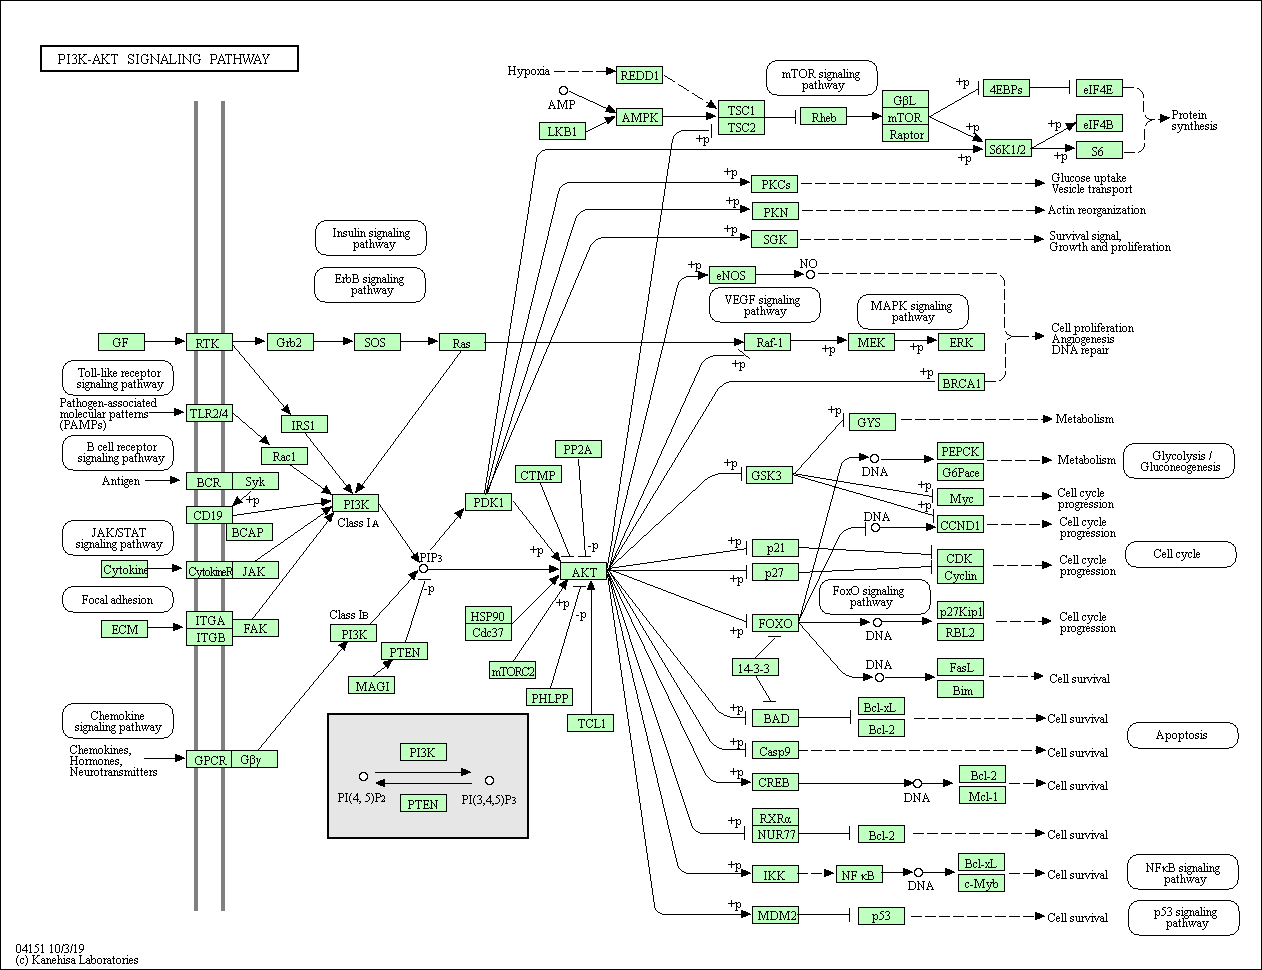

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
s = REST.kegg_get("hsa04151","image").read()
Image(s)

In [ ]:
s = REST.kegg_get("hsa04151","kgml").read()
print(s)

In [ ]:
from IPython.display import Image
from Bio.KEGG.KGML.KGML_parser import read
import random
s = REST.kegg_get("hsa04151","kgml").read()
tmp_list = [str(read(s).relations[i]) for i in range(read(s).relations.__len__())]

In [ ]:
tmp_list[0].split("\n")
#read(s).relations.__len__()

In [ ]:
dict_kegg_tmp = []

for i in range(read(s).relations.__len__()):
  try:
    node_1 = tmp_list[i].split("\n")[3]
    node_1_type = tmp_list[i].split("\n")[4]
    node_2 = tmp_list[i].split("\n")[11]
    node_2_type = tmp_list[i].split("\n")[12]
    relations = tmp_list[i].split("\n")[18]
    tmp_res_02 = [node_2,"=",node_1,"[","Relation:",relations,"and type:" ,node_1_type,"&",node_2_type,"]"] 
    res_bool = " ".join(tmp_res_02).replace("Names:","").replace("Type:","")
    open("Boolean_final.txt","a").write(res_bool + "\n")
  except Exception:
    pass

In [ ]:
d = open("test_03.txt", "r")
d.read()

'PPrel -->  hsa:3164 =  hsa:100533105 hsa:10110 hsa:23678 hsa:6446\nPPrel --|  hsa:23035 hsa:23239 =  hsa:2997 hsa:2998\nPPrel -->  undefined =  hsa:10000 hsa:207 hsa:208\nPPrel -->  undefined =  hsa:6009\nPPrel -->  cpd:C05981 =  hsa:596\nPPrel --|  hsa:1436 hsa:1956 hsa:1969 hsa:2064 hsa:2065 hsa:2066 hsa:2260 hsa:2261 hsa:2263 hsa:2264 hsa:2321 hsa:2322 hsa:2324 hsa:3480 hsa:3643 hsa:3791 hsa:3815 hsa:4233 hsa:4804 hsa:4914 hsa:4915 hsa:5156 hsa:5159 hsa:7010 =  hsa:595\nPPrel -->  hsa:6198 hsa:6199 =  cpd:C05981\nGErel --|  undefined =  hsa:596\nGErel -->  hsa:2309 =  hsa:5170\nGErel --|  hsa:10000 hsa:207 hsa:208 =  hsa:10000 hsa:207 hsa:208\nPPrel -->  hsa:572 =  hsa:5562 hsa:5563\nPPrel -->  hsa:2309 =  hsa:4193\nPPrel -->  hsa:4193 =  hsa:1978\nPPrel -->  hsa:28227 hsa:55012 hsa:5515 hsa:5516 hsa:5518 hsa:5519 hsa:5520 hsa:5521 hsa:5522 hsa:5523 hsa:5525 hsa:5526 hsa:5527 hsa:5528 hsa:5529 hsa:55844 =  hsa:4193\nPPrel -->  hsa:3164 =  hsa:672\nGErel -->  hsa:3265 hsa:3845 hsa:4

##Cell line

Useful resource: https://depmap.org/portal/download/

In [261]:
cell_line = pd.read_csv("https://github.com/kittisaktaoma/colab_practice/raw/master/data/Mutation_profile.csv.gz")
cell_line.iloc[:,0].unique()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['CAL148', 'DU4475', 'BT483', 'CAMA1', 'EFM19', 'HCC1428',
       'HCC1500', 'KPL1', 'MCF7', 'MDAMB134VI', 'MFM223', 'SUM185PE',
       'SUM44PE', 'SUM52PE', 'T47D', 'UACC812', 'ZR751', 'AU565', 'BT474',
       'EFM192A', 'HCC1419', 'HCC202', 'HCC2218', 'MDAMB175VII',
       'MDAMB361', 'MDAMB415', 'MDAMB453', 'SKBR3', 'UACC893', 'ZR7530',
       'BT549', 'CAL120', 'CAL51', 'HCC1395', 'HMC18', 'HS578T',
       'MDAMB157', 'MDAMB231', 'MDAMB436', 'SUM149PT', 'SUM159PT', 'BT20',
       'CAL851', 'HCC1143', 'HCC1187', 'HCC1569', 'HCC1599', 'HCC1806',
       'HCC1937', 'HCC1954', 'HCC2157', 'HCC38', 'HCC70', 'HDQP1',
       'JIMT1', 'MDAMB468', 'SUM102PT', 'SUM1315MO2', 'SUM229PE', '21NT',
       'COLO824', 'EVSAT', 'MDAMB330', 'MRKNU1', 'OCUBM', 'VP229',
       'YMB1E'], dtype=object)

In [262]:
df_model = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/data/sample.txt",sep="\t").iloc[:,9]
df_model_list = list(df_model.unique())
df_model_list

['EFM192B',
 'KPL1',
 'MDAMB436',
 'OCUBM',
 'T-47D',
 'ZR751',
 'MDA-MB-468',
 'MDA-MB-231',
 'BT-549',
 'HS 578T',
 'MCF7']

In [ ]:
new_name_01 = [i.replace("-","") for i in df_model_list]
new_name_final = [i.replace(" ","") for i in new_name_01]
new_name_final

In [253]:
cell_line_final = cell_line[cell_line["cell_line_display_name"].isin(new_name_final)]
cell_line_final

,cell_line_display_name,lineage_4,VPS13D,AADACL4,IFNLR1,MACO1,ZSCAN20,POU3F1,MAST2,GBP4,VAV3,NBPF20,FLG2,RHBG,FCRL5,SPTA1,CFAP126,DUSP12,QSOX1,EPRS1,RGS7,ZBTB18,PCBD1,ECD,ZNF503,PDZD7,SORCS1,GFRA1,CPXM2,TCERG1L,MUC5B,BRSK2,SYT8,OSBPL5,MMP26,BBOX1,METTL15,KBTBD4,OR4C3,OR4C12,...,CASP6,CD14,H2AC15,SMAP1,LHFPL3,TRMT12,DEPP1,TMEM116,EMP3,HOPX,EFNA4,TACR2,ENO4,FOXN4,PSMC6,PCTP,TST,KLF15,CEP19,KLF3,PPP1R18,PSORS1C1,AFG1L,SEC61G,DOK2,ACER2,TNFSF8,MED8,IFI27L2,GFPT1,KLHL41,KRTAP25-1,USP46,CRHBP,AGPAT1,MAN1A1,PURB,CTAGE6,OR1L3,S100G
7,KPL1,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,MCF7,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,T47D,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,ZR751,Luminal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,BT549,Basal B,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,HS578T,Basal B,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37,MDAMB231,Basal B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
38,MDAMB436,Basal B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55,MDAMB468,Basal A,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64,OCUBM,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# Data Preparation

##Filter available cell line

In [315]:
df_model = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/data/sample.txt",sep="\t").iloc[:,np.r_[1,2,9,6]]
df_model["cell_line_name"].replace({"T-47D": "T47D", 
                                    "MDA-MB-468": "MDAMB468",
                                    "MDA-MB-231": "MDAMB231",
                                    "BT-549": "BT549",
                                    "HS 578T": "HS578T"}, inplace=True)
filter_list = cell_line_final.iloc[:,0].unique()
final_df = df_model_04[df_model_04["cell_line_name"].isin(filter_list)]
final_df

,drug_row,drug_col,cell_line_name,synergy_loewe
0,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23
1,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50
2,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33
3,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25
4,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41
...,...,...,...,...
24561,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55
24562,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20
24563,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43
24564,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69


In [316]:
df_model_02 = final_df.groupby(['drug_row','drug_col','cell_line_name']).agg({'synergy_loewe': 'mean'}).reset_index()
df_model_03 = df_model_02[df_model_02.drug_row.isin(newDF.drug.unique().tolist())]
df_model_04 = df_model_03[df_model_03.drug_col.isin(newDF.drug.unique().tolist())]
df_model_04

,drug_row,drug_col,cell_line_name,synergy_loewe
0,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,BT549,0.23
1,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,HS578T,-11.50
2,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MCF7,-49.33
3,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB231,-4.25
4,5-FLUORO-2'-DEOXYURIDINE,AMIFOSTINE,MDAMB468,-6.41
...,...,...,...,...
24561,ZOLINZA,ZOLEDRONIC ACID,HS578T,-3.55
24562,ZOLINZA,ZOLEDRONIC ACID,MCF7,-7.20
24563,ZOLINZA,ZOLEDRONIC ACID,MDAMB231,-7.43
24564,ZOLINZA,ZOLEDRONIC ACID,MDAMB468,-7.69


##Filter available drug from target protein and drug structure

In [309]:
#target protein & drug structure
available_drug = list(target_protein.keys() & feat_mat.keys())
len(available_drug)

122

In [310]:
target_protein_01 = {k: target_protein[k] for k in set(available_drug) & set(target_protein.keys())}
drug_number = list(target_protein_01.values()).__len__()
newDF = pd.DataFrame() 

for i in range(drug_number):
  df_annotated = pd.DataFrame(pd.DataFrame(list(target_protein_01.values())[i].tolist()))
  df_annotated["drug"] = list(target_protein_01.keys())[i]
  newDF = df_annotated.append(newDF)
newDF.columns = ['drug','protein']
newDF

,drug,protein
0,QUINACRINE HYDROCHLORIDE,9606.ENSP00000269305
1,QUINACRINE HYDROCHLORIDE,9606.ENSP00000368752
2,QUINACRINE HYDROCHLORIDE,9606.ENSP00000312286
3,QUINACRINE HYDROCHLORIDE,9606.ENSP00000356436
4,QUINACRINE HYDROCHLORIDE,9606.ENSP00000265023
...,...,...
5,BEZ-235,9606.ENSP00000340691
6,BEZ-235,9606.ENSP00000358022
7,BEZ-235,9606.ENSP00000376943
8,BEZ-235,9606.ENSP00000417281


###Target Protein

In [317]:
crosstab_df_target_protein = pd.crosstab(remove_final["drug"],remove_final['protein']).stack().reset_index(name='Freq')
crosstab_df_target_protein_02 = pd.pivot_table(crosstab_df_target_protein,index='drug', columns='protein',values='Freq').reset_index()
crosstab_df_target_protein_03 = crosstab_df_target_protein_02.iloc[:,0:]
crosstab_df_target_protein_03

protein,drug,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220809,9606.ENSP00000221130,9606.ENSP00000221930,9606.ENSP00000222390,9606.ENSP00000222982,9606.ENSP00000223095,9606.ENSP00000225474,9606.ENSP00000225577,9606.ENSP00000226413,9606.ENSP00000226730,9606.ENSP00000227507,9606.ENSP00000227758,9606.ENSP00000228682,9606.ENSP00000229135,9606.ENSP00000229239,9606.ENSP00000231449,9606.ENSP00000231509,9606.ENSP00000231790,9606.ENSP00000231948,9606.ENSP00000233146,9606.ENSP00000237612,...,9606.ENSP00000387699,9606.ENSP00000388648,9606.ENSP00000388902,9606.ENSP00000391676,9606.ENSP00000393583,9606.ENSP00000394932,9606.ENSP00000396308,9606.ENSP00000396704,9606.ENSP00000398495,9606.ENSP00000398698,9606.ENSP00000399985,9606.ENSP00000400175,9606.ENSP00000402084,9606.ENSP00000402861,9606.ENSP00000408632,9606.ENSP00000408695,9606.ENSP00000408860,9606.ENSP00000410076,9606.ENSP00000411532,9606.ENSP00000412237,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000464149
0,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5-FU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ABIRATERONE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ABT-888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ACTINOMYCIN D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,VINCRISTINE SULFATE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
101,VINORELBINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,VISMODEGIB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,ZOLEDRONIC ACID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
newDF_prot = pd.DataFrame()

for i in range(df_model_04.shape[0]):
  print(i)
  index_drug = df_model_04.iloc[df_model_04.shape[0]-1-i,:2].tolist()
  drug_row = crosstab_df_target_protein_03[crosstab_df_target_protein_03.drug == index_drug[0]]

  drug_row_02 = drug_row.rename(columns={'drug': 'drug_row'})
  drug_col = crosstab_df_target_protein_03[crosstab_df_target_protein_03["drug"] == index_drug[1]]

  drug_col_02 = drug_col.rename(columns={'drug': 'drug_col'})
  res_app = pd.concat([drug_row_02.reset_index(drop=True),drug_col_02.reset_index(drop=True)],axis=1)

  res_app_2 = res_app.sort_index(axis=1).iloc[:,:988]
  res_app_tmp = res_app.sort_index(axis=1).iloc[:,988:]
  
  final_df = pd.concat([res_app_tmp,res_app_2],axis=1)
  newDF_prot = final_df.append(newDF_prot) 

In [ ]:
newDF_prot

protein,drug_col,drug_row,9606.ENSP00000001008,9606.ENSP00000001008,9606.ENSP00000001146,9606.ENSP00000001146,9606.ENSP00000013807,9606.ENSP00000013807,9606.ENSP00000037502,9606.ENSP00000037502,9606.ENSP00000080059,9606.ENSP00000080059,9606.ENSP00000206249,9606.ENSP00000206249,9606.ENSP00000211122,9606.ENSP00000211122,9606.ENSP00000215832,9606.ENSP00000215832,9606.ENSP00000216117,9606.ENSP00000216117,9606.ENSP00000216330,9606.ENSP00000216330,9606.ENSP00000216714,9606.ENSP00000216714,9606.ENSP00000216911,9606.ENSP00000216911,9606.ENSP00000217133,9606.ENSP00000217133,9606.ENSP00000217185,9606.ENSP00000217185,9606.ENSP00000217426,9606.ENSP00000217426,9606.ENSP00000218032,9606.ENSP00000218032,9606.ENSP00000219431,9606.ENSP00000219431,9606.ENSP00000219700,9606.ENSP00000219700,9606.ENSP00000220764,9606.ENSP00000220764,...,9606.ENSP00000413074,9606.ENSP00000413074,9606.ENSP00000414334,9606.ENSP00000414334,9606.ENSP00000417281,9606.ENSP00000417281,9606.ENSP00000417517,9606.ENSP00000417517,9606.ENSP00000418532,9606.ENSP00000418532,9606.ENSP00000418960,9606.ENSP00000418960,9606.ENSP00000419692,9606.ENSP00000419692,9606.ENSP00000419782,9606.ENSP00000419782,9606.ENSP00000420168,9606.ENSP00000420168,9606.ENSP00000425561,9606.ENSP00000425561,9606.ENSP00000427562,9606.ENSP00000427562,9606.ENSP00000430075,9606.ENSP00000430075,9606.ENSP00000430432,9606.ENSP00000430432,9606.ENSP00000434516,9606.ENSP00000434516,9606.ENSP00000441927,9606.ENSP00000441927,9606.ENSP00000457706,9606.ENSP00000457706,9606.ENSP00000459962,9606.ENSP00000459962,9606.ENSP00000462196,9606.ENSP00000462196,9606.ENSP00000463999,9606.ENSP00000463999,9606.ENSP00000464149,9606.ENSP00000464149
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TOPOTECAN,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,TRIETHYLENEMELAMINE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,VINBLASTINE SULFATE,ZOLINZA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
newDF_prot_02 = pd.DataFrame() 
i = list(newDF_prot.iloc[:,2:].columns.unique())
for k in i:
  x = pd.DataFrame(newDF_prot.loc[:,k].sum(axis=1))
  x.columns = [k]
  newDF_prot_02 = pd.concat([x,newDF_prot_02],axis=1)
final_df_ordinal = pd.concat([newDF_prot.iloc[:,:2], newDF_prot_02],axis=1)
print(final_df_ordinal)

                             drug_col  ... 9606.ENSP00000001008
0                          AMIFOSTINE  ...                    0
0   AMINOLEVULINIC ACID HYDROCHLORIDE  ...                    0
0                         ANASTROZOLE  ...                    0
0                    ANTIBIOTIC AD 32  ...                    0
0                 ANTIBIOTIC AY 22989  ...                    1
..                                ...  ...                  ...
0                           TOPOTECAN  ...                    0
0             TOPOTECAN HYDROCHLORIDE  ...                    0
0                 TRIETHYLENEMELAMINE  ...                    0
0                 VINBLASTINE SULFATE  ...                    0
0                     ZOLEDRONIC ACID  ...                    0

[4211 rows x 496 columns]


In [ ]:
final_df_ordinal.iloc[:,:2]

,drug_col,drug_row
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE
0,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE
0,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE
0,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE
...,...,...
0,TOPOTECAN,ZOLINZA
0,TOPOTECAN HYDROCHLORIDE,ZOLINZA
0,TRIETHYLENEMELAMINE,ZOLINZA
0,VINBLASTINE SULFATE,ZOLINZA


In [ ]:
score = pd.DataFrame(df_model_04.iloc[:,2]).reset_index(drop=True)
f1 = final_df_ordinal.reset_index(drop=True)
target_protein_df = pd.concat([f1,score],axis=1)
target_protein_df

,drug_col,drug_row,9606.ENSP00000464149,9606.ENSP00000463999,9606.ENSP00000462196,9606.ENSP00000459962,9606.ENSP00000457706,9606.ENSP00000441927,9606.ENSP00000434516,9606.ENSP00000430432,9606.ENSP00000430075,9606.ENSP00000427562,9606.ENSP00000425561,9606.ENSP00000420168,9606.ENSP00000419782,9606.ENSP00000419692,9606.ENSP00000418960,9606.ENSP00000418532,9606.ENSP00000417517,9606.ENSP00000417281,9606.ENSP00000414334,9606.ENSP00000413074,9606.ENSP00000412237,9606.ENSP00000411532,9606.ENSP00000410076,9606.ENSP00000408860,9606.ENSP00000408695,9606.ENSP00000408632,9606.ENSP00000402861,9606.ENSP00000402084,9606.ENSP00000400175,9606.ENSP00000399985,9606.ENSP00000398698,9606.ENSP00000398495,9606.ENSP00000396704,9606.ENSP00000396308,9606.ENSP00000394932,9606.ENSP00000393583,9606.ENSP00000391676,9606.ENSP00000388902,...,9606.ENSP00000233146,9606.ENSP00000231948,9606.ENSP00000231790,9606.ENSP00000231509,9606.ENSP00000231449,9606.ENSP00000229239,9606.ENSP00000229135,9606.ENSP00000228682,9606.ENSP00000227758,9606.ENSP00000227507,9606.ENSP00000226730,9606.ENSP00000226413,9606.ENSP00000225577,9606.ENSP00000225474,9606.ENSP00000223095,9606.ENSP00000222982,9606.ENSP00000222390,9606.ENSP00000221930,9606.ENSP00000221130,9606.ENSP00000220809,9606.ENSP00000220764,9606.ENSP00000219700,9606.ENSP00000219431,9606.ENSP00000218032,9606.ENSP00000217426,9606.ENSP00000217185,9606.ENSP00000217133,9606.ENSP00000216911,9606.ENSP00000216714,9606.ENSP00000216330,9606.ENSP00000216117,9606.ENSP00000215832,9606.ENSP00000211122,9606.ENSP00000206249,9606.ENSP00000080059,9606.ENSP00000037502,9606.ENSP00000013807,9606.ENSP00000001146,9606.ENSP00000001008,synergy_loewe
0,AMIFOSTINE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10.583333
1,AMINOLEVULINIC ACID HYDROCHLORIDE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-8.270000
2,ANASTROZOLE,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-3.548333
3,ANTIBIOTIC AD 32,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-5.140000
4,ANTIBIOTIC AY 22989,5-FLUORO-2'-DEOXYURIDINE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-6.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,TOPOTECAN,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.773750
4207,TOPOTECAN HYDROCHLORIDE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-12.246667
4208,TRIETHYLENEMELAMINE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.803333
4209,VINBLASTINE SULFATE,ZOLINZA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-1.546667


###Drug structure

In [ ]:
drug_availale_in_target_protein = newDF.iloc[:,1].unique()
drug_availale_in_target_protein

array(['TEMOZOLOMIDE', 'NSC-127716', 'VISMODEGIB', 'METHOTREXATE',
       'TOPOTECAN HYDROCHLORIDE', 'PLICAMYCIN', 'ERLOTINIB', 'DASATINIB',
       'BLEOMYCIN', 'VINBLASTINE', 'ABT-888', 'EXEMESTANE',
       'MERCAPTOPURINE', 'VINBLASTINE SULFATE', 'ERLOTINIB HYDROCHLORIDE',
       'LETROZOLE', 'THIOTEPA', 'ANASTROZOLE', 'BORTEZOMIB', 'AXITINIB',
       'DAUNORUBICIN HYDROCHLORIDE', 'CISPLATINO', 'MEGESTROL ACETATE',
       'MITOTANE', 'MK-8669', 'IMATINIB', 'PROCARBAZINE HYDROCHLORIDE',
       'BENDAMUSTINE HYDROCHLORIDE', 'SORAFENIB', 'GEFITINIB',
       'MECHLORETHAMINE HYDROCHLORIDE', 'METHOXSALEN', 'GEMCITABINE',
       'MK-4827', 'NAVELBINE DITARTRATE (TN)', 'CHLORAMBUCIL', 'MK-2206',
       'DINACICLIB', 'MK-5108', 'CABAZITAXEL', 'MITOMYCINE',
       'RUXOLITINIB', 'BUSULFAN', 'ZOLINZA', 'OXALIPLATIN', 'CELECOXIB',
       'CYTARABINE HYDROCHLORIDE', 'LAPATINIB', 'TOPOTECAN', 'IFOSFAMIDE',
       'AMIFOSTINE', 'ABIRATERONE', 'MELPHALAN HYDROCHLORIDE',
       'AMINOLEVULINIC ACID 

In [ ]:
drug_1_index = list(final_df_ordinal.iloc[:,0])
drug_2_index = list(final_df_ordinal.iloc[:,1])

#### Drug row

In [ ]:
drug_structure_1_list = []
drug_1_index = final_df_ordinal.iloc[:,0]
drug_structure_01 = {k: feat_mat[k] for k in set(drug_availale_in_target_protein) & set(feat_mat.keys())}
for i in drug_1_index:
  selected_drug = drug_structure_01[i].tolist()
  drug_structure_1_list.append(selected_drug)

#### Drug column

In [ ]:
drug_structure_2_list = []
drug_2_index = final_df_ordinal.iloc[:,1]
drug_structure_01 = {k: feat_mat[k] for k in set(drug_availale_in_target_protein) & set(feat_mat.keys())}
for i in drug_2_index:
  selected_drug = drug_structure_01[i]
  drug_structure_2_list.append(selected_drug)

In [ ]:
drug_structure_1_array = np.array(drug_structure_1_list).astype('float32')
drug_structure_2_array = np.array(drug_structure_2_list).astype('float32')


#Model

In [ ]:
class GraphConv(Layer):
    
    """
    GraphConv require two inputs: padding feature and padding adjacency matrix of each drug

    """
    def __init__(self,output_dim,activation="sigmoid"):
        super().__init__()
        self.units = output_dim
        self.activation_function = activation

    def build(self, input_shape):
        
        """ 
        weight in GCN : 
        row is number of feature
        column is the number of output node

        """
        self.w = self.add_weight(name='w',
            shape=(input_shape[-1], self.units), 
            initializer="random_normal",
            trainable=True)
        
    

    def call(self,inputs):
      """
      Inputs = padding feature matrix 
      A = padding adjacency matrix

      """
      if self.activation_function == 'relu':
        return relu(inputs @ self.w)
      else:
        return sigmoid(inputs @ self.w)

## Model Achitecture

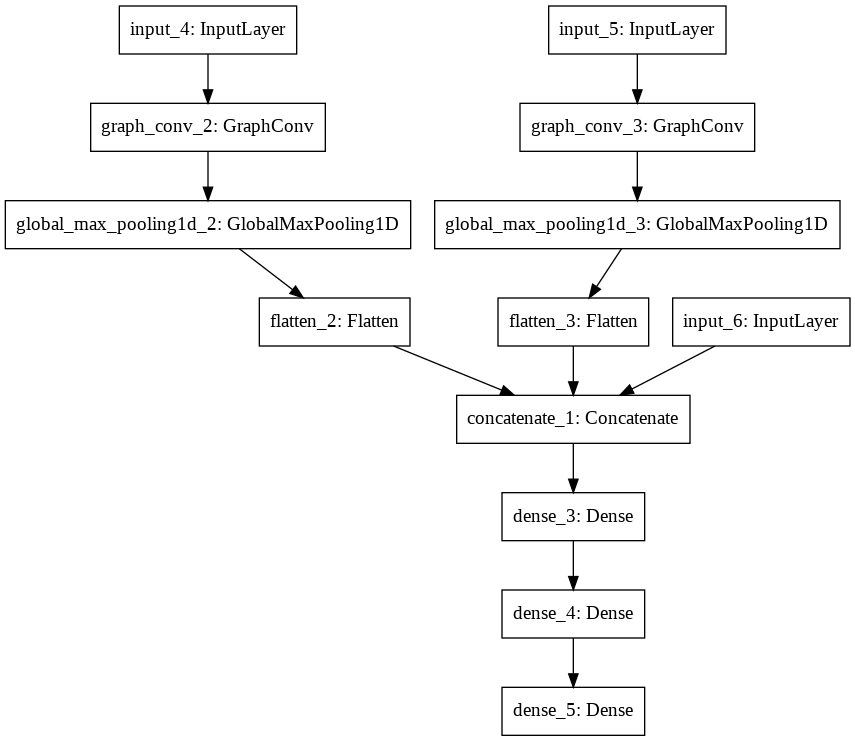

In [ ]:
#drug structure_1
drug_01 = Input(shape=(96,5))
drug_01_layer1 = GraphConv(2,activation='relu')(drug_01)
drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
flat1 = Flatten()(drug_01_pool)

#drug structure_2
drug_02 = Input(shape=(96,5))
drug_02_layer1 = GraphConv(2,activation='relu')(drug_02)
drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
flat2 = Flatten()(drug_02_pool)

#target protein
flat3 = Input(shape=(494,))

#merge input models
merge = concatenate([flat1,flat2,flat3])

#interpretation model
# interpretation model
hidden1 = Dense(2000, activation='relu')(merge)
hidden2 = Dense(2000, activation='relu')(hidden1)
output = Dense(1)(hidden2)
model = Model(inputs=[flat3,drug_01,drug_02], outputs=output)
plot_model(model, to_file='multilayer_perceptron_graph.png')

## Customized Evaluation metric

Pearson correlation coefficlent : $r_{xy} = \frac{\sum\left((x-\overline{x})(y-\overline{y})\right)}{\sqrt{\sum(x-\overline{x})^2\sum(y-\overline{y})^2}} $

In [ ]:
def correlation(y_actual, y_predict):    
    y_actual_me = tf.math.reduce_mean(y_actual)
    y_predict_me = tf.math.reduce_mean(y_predict)
    y_actual_diff, y_predict_diff = y_actual-y_actual_me, y_predict-y_predict_me

    num = tf.math.reduce_sum(tf.multiply(y_predict_diff,y_actual_diff))
    deno = tf.math.pow(tf.multiply(tf.math.reduce_sum(tf.math.pow(y_actual_diff,2)),
                              tf.math.reduce_sum(tf.math.pow(y_predict_diff,2))),0.5) 
    res = num/deno
    return res

def correlation_neg(y_actual, y_predict):    
    y_actual_me = tf.math.reduce_mean(y_actual)
    y_predict_me = tf.math.reduce_mean(y_predict)
    y_actual_diff, y_predict_diff = y_actual-y_actual_me, y_predict-y_predict_me

    num = tf.math.reduce_sum(tf.multiply(y_predict_diff,y_actual_diff))
    deno = tf.math.pow(tf.multiply(tf.math.reduce_sum(tf.math.pow(y_actual_diff,2)),
                              tf.math.reduce_sum(tf.math.pow(y_predict_diff,2))),0.5) 
    res = -num/deno
    return res

##Model with Target Protein

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
from keras.optimizers import RMSprop

def model_target_protein(layer_1 = 1000,activation_1 = "relu",layer_2 = 1000,activation_2 = "relu",optimizer_algorithm = "1",lr = "0.001",dropout_1=0,dropout_2=0):
  #target protein
  flat1 = Input(shape=(494,))
  #interpretation model
  hidden1 = Dense(layer_1,activation=activation_1)(flat1)
  hidden1_D = Dropout(rate=dropout_1)(hidden1)
  hidden2 = Dense(layer_2,activation=activation_2)(hidden1_D)
  hidden2_D = Dropout(rate=dropout_2)(hidden2)
  output = Dense(1)(hidden2_D)
  model = Model(inputs=flat1, outputs=output)

  #optimizer
  if optimizer_algorithm == "1": 
    opt = Adam(learning_rate=lr)
  elif optimizer_algorithm == "2":
    opt = RMSprop(learning_rate=lr)

  model.compile(optimizer=opt,
                loss=correlation_neg,
                metrics=correlation)
  return model

In [ ]:
# Create a KerasRegressor
# Define the parameters to try out
params = {'activation_1': ["relu", "tanh"],
          'activation_2': ["relu", "tanh"],
          'layer_1': np.arange(500, 10000,1).tolist(),
          'layer_2': np.arange(500, 10000,1).tolist(),
          'dropout_1' : np.arange(0.01, 0.05, 0.001).tolist(),
          'dropout_2' : np.arange(0.01, 0.05, 0.001).tolist(),
          'batch_size': [64,128], 
          'epochs': [30],
          'optimizer_algorithm' : ["1","2"],
          'lr': np.arange(0.000000001, 0.01, 0.00000001).tolist()}

model = KerasRegressor(build_fn = model_target_protein,
                       verbose = 1)

kfold = KFold(n_splits=3, shuffle=True,random_state=123)
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv =kfold,
                                   n_iter=3,
                                   return_train_score=True,
                                   random_state=123,verbose=1)

X_train, X_test, y_train, y_test = train_test_split(target_protein_df.iloc[:,2:496],np.array(target_protein_df.iloc[:,496]), test_size=0.20)
random_search_results = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


36/36 [==============================] - 1s 4ms/step - loss: -0.2775 - correlation: 0.2773
Epoch 2/30
36/36 [==============================] - 0s 4ms/step - loss: -0.5708 - correlation: 0.5704
Epoch 3/30
36/36 [==============================] - 0s 4ms/step - loss: -0.6329 - correlation: 0.6327
Epoch 4/30
36/36 [==============================] - 0s 4ms/step - loss: -0.6865 - correlation: 0.6867
Epoch 5/30
36/36 [==============================] - 0s 4ms/step - loss: -0.7962 - correlation: 0.7964
Epoch 6/30
36/36 [==============================] - 0s 3ms/step - loss: -0.8607 - correlation: 0.8606
Epoch 7/30
36/36 [==============================] - 0s 4ms/step - loss: -0.8797 - correlation: 0.8794
Epoch 8/30
36/36 [==============================] - 0s 4ms/step - loss: -0.8886 - correlation: 0.8885
Epoch 9/30
36/36 [==============================] - 0s 4ms/step - loss: -0.9023 - correlation: 0.9015
Epoch 10/30
36/36 [==============================] - 0s 4ms/step - loss: -0.8783 - correlatio

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.0s finished


27/27 [==============================] - 1s 7ms/step - loss: -0.3287 - correlation: 0.3290
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: -0.4889 - correlation: 0.4888
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: -0.5057 - correlation: 0.5055
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: -0.5555 - correlation: 0.5556
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: -0.5489 - correlation: 0.5487
Epoch 6/30
27/27 [==============================] - 0s 7ms/step - loss: -0.6142 - correlation: 0.6143
Epoch 7/30
27/27 [==============================] - 0s 7ms/step - loss: -0.6842 - correlation: 0.6841
Epoch 8/30
27/27 [==============================] - 0s 7ms/step - loss: -0.7480 - correlation: 0.7479
Epoch 9/30
27/27 [==============================] - 0s 7ms/step - loss: -0.7711 - correlation: 0.7711
Epoch 10/30
27/27 [==============================] - 0s 7ms/step - loss: -0.7989 - correlatio

In [ ]:
res_predict = random_search_results.predict(X_test)
res_predict_02 = res_predict.astype('float64')
y_test_02 = y_test.astype('float64')
res_test_correlation = np.array(correlation(y_test_02,res_predict_02))

res_train_correlation = np.array(random_search_results.cv_results_["mean_train_score"][random_search_results.best_index_])
res_validation_correlation = np.array(random_search_results.cv_results_["mean_test_score"][random_search_results.best_index_])
all_res = np.array([res_train_correlation,res_validation_correlation,res_test_correlation])
all_res

7/7 [==============================] - 0s 3ms/step


array([0.94958937, 0.75342915, 0.81201271])

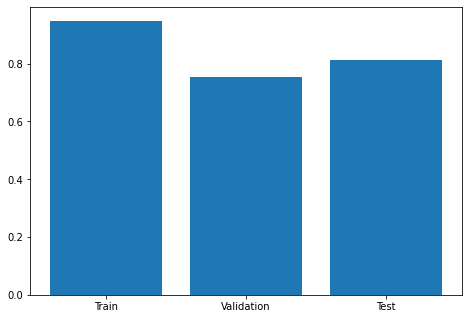

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
langs = ['Train', 'Validation', 'Test']
students = all_res
ax.bar(langs,students)
plt.show()

##Model with drug structure

In [ ]:
import pandas as pd
import numpy as np
target = np.ones(25)
target[-5:] = 0
df = pd.DataFrame({'col_a':np.random.random(25),
                  'target':target})

In [ ]:
X = df.col_a
y = df.target
kf = KFold(n_splits=4)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [0 1 2 3 4 5 6]
TRAIN: [ 0  1  2  3  4  5  6 13 14 15 16 17 18 19 20 21 22 23 24] TEST: [ 7  8  9 10 11 12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 19 20 21 22 23 24] TEST: [13 14 15 16 17 18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19 20 21 22 23 24]


In [ ]:
kf = KFold(n_splits=4, shuffle=True, random_state=1)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  4  5  6  7  8  9 11 12 15 16 19 20 22 23 24] TEST: [ 3 10 13 14 17 18 21]
TRAIN: [ 0  1  3  5  8  9 10 11 12 13 14 15 16 17 18 21 22 23 24] TEST: [ 2  4  6  7 19 20]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 17 18 19 20 21 23] TEST: [ 0  1 15 16 22 24]
TRAIN: [ 0  1  2  3  4  6  7 10 13 14 15 16 17 18 19 20 21 22 24] TEST: [ 5  8  9 11 12 23]


In [ ]:
len(train)

3159

In [ ]:
def tune_nn_model(hp):
  #drug structure_1
  drug_01 = Input(shape=(96,5))
  drug_01_layer1 = GraphConv(2,activation='relu')(drug_01)
  drug_01_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_01_layer1)
  flat1 = Flatten()(drug_01_pool)

  #drug structure_2
  drug_02 = Input(shape=(96,5))
  drug_02_layer1 = GraphConv(2,activation='relu')(drug_02)
  drug_02_pool = tf.keras.layers.GlobalMaxPooling1D()(drug_02_layer1)
  flat2 = Flatten()(drug_02_pool)

  #target protein
  flat3 = Input(shape=(494,))

  #merge input models
  merge = concatenate([flat1,flat2,flat3])

  #interpretation model
  hidden1 = Dense(units=hp.Int(
      'units',
       min_value=1000,
       max_value=3000,
       default=128
       ),
       activation=hp.Choice(
       'dense_activation',
       values=['relu', 'tanh', 'sigmoid']
       ))(merge)
  
  hidden1_D = Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25
            ))(hidden1)

  hidden2 = Dense(units=hp.Int(
        'units_2',
        min_value=1000,
        max_value=10000,
        default=128
    ),
  activation=hp.Choice(
        'dense_activation_2',
        values=['relu', 'tanh', 'sigmoid']
    ))(hidden1_D)

  hidden2_D = Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25
            ))(hidden2)

  output = Dense(1)(hidden2_D)

  model = Model(inputs=[flat3,drug_01,drug_02], outputs=output)
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-5,max_value=1e-2,sampling='LOG',default=1e-3)),loss='mse',
                  metrics=['mse',correlation])
  return model

In [ ]:
hist_test = model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 16ms/step - loss: 85.0177 - mse: 85.0177 - correlation: 0.5113


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = b_tuner.get_best_models(num_models=1)[0]

hist_train = model.fit(x=[np.array(target_protein_df.iloc[:,2:496]),drug_structure_1_array,drug_structure_2_array],
             y=np.array(target_protein_df.iloc[:,496]),
             batch_size=128,
             epochs=100,
             validation_split=0.33)

In [ ]:
hist_test

[85.01769256591797, 85.01769256591797, 0.5112579464912415]